In [1]:
%matplotlib inline

from config import configs

import os
import io
import numpy as np
import matplotlib
import timeit
import random
import pprint
import cv2

import matplotlib.pyplot as plt

from datetime import datetime
from scipy.interpolate import griddata
from core.kitti import KITTI, range_view
from pixor_utils.model_utils import load_model, save_model
from data_utils.training_gen import TrainingGenerator
from data_utils.generator import Generator, KITTIGen
from tt import bev
from pixor_utils.post_processing import nms_bev
from test_utils.unittest import test_pc_encoder, test_target_encoder
from encoding_utils.pointcloud_encoder import OccupancyCuboidKITTI

In [2]:
DS_DIR = os.path.expanduser(configs['dataset_path'])

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = configs["gpu_id"]
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 

In [3]:
import tensorflow as tf
import tensorflow.keras.backend as K

device_name = tf.test.gpu_device_name()
os.system('clear')
print('Conncted to Device:', device_name)

Conncted to Device: /device:GPU:0


In [4]:
# Point Cloud Encoder
INPUT_SHAPE = configs['input_shape']

# Training
BATCH_SIZE = configs['hyperparams']['batch_size']
LEARNING_RATE = configs['hyperparams']['lr']
EPOCHS = configs['hyperparams']['epochs']
NUM_THREADS = configs['hyperparams']['num_threads']
MAX_Q_SIZE = configs['hyperparams']['max_q_size']

In [5]:
kitti = KITTI(DS_DIR, configs['training_target'])

train_ids = kitti.get_ids('train')
val_ids = kitti.get_ids('val')
micro_ids = kitti.get_ids('micro')

In [6]:
pc_encoder = OccupancyCuboidKITTI(0, 70, -35, 35, -1, 3, [0.1, 0.1, 4])

In [7]:
cur_idx = train_ids[25]

In [8]:
pc, ref = kitti.get_velo(cur_idx, workspace_lim=((-35, 35), (-1, 3), (0, 70)), use_fov_filter=True)
print('pc.shape', pc.shape, 'ref.shape', ref.shape)

pc.shape (3, 17366) ref.shape (1, 17366)


In [9]:
encoded_pc = pc_encoder.encode(pc.T)
print('encoded_pc.shape', encoded_pc.shape)

encoded_pc.shape (700, 700, 1)


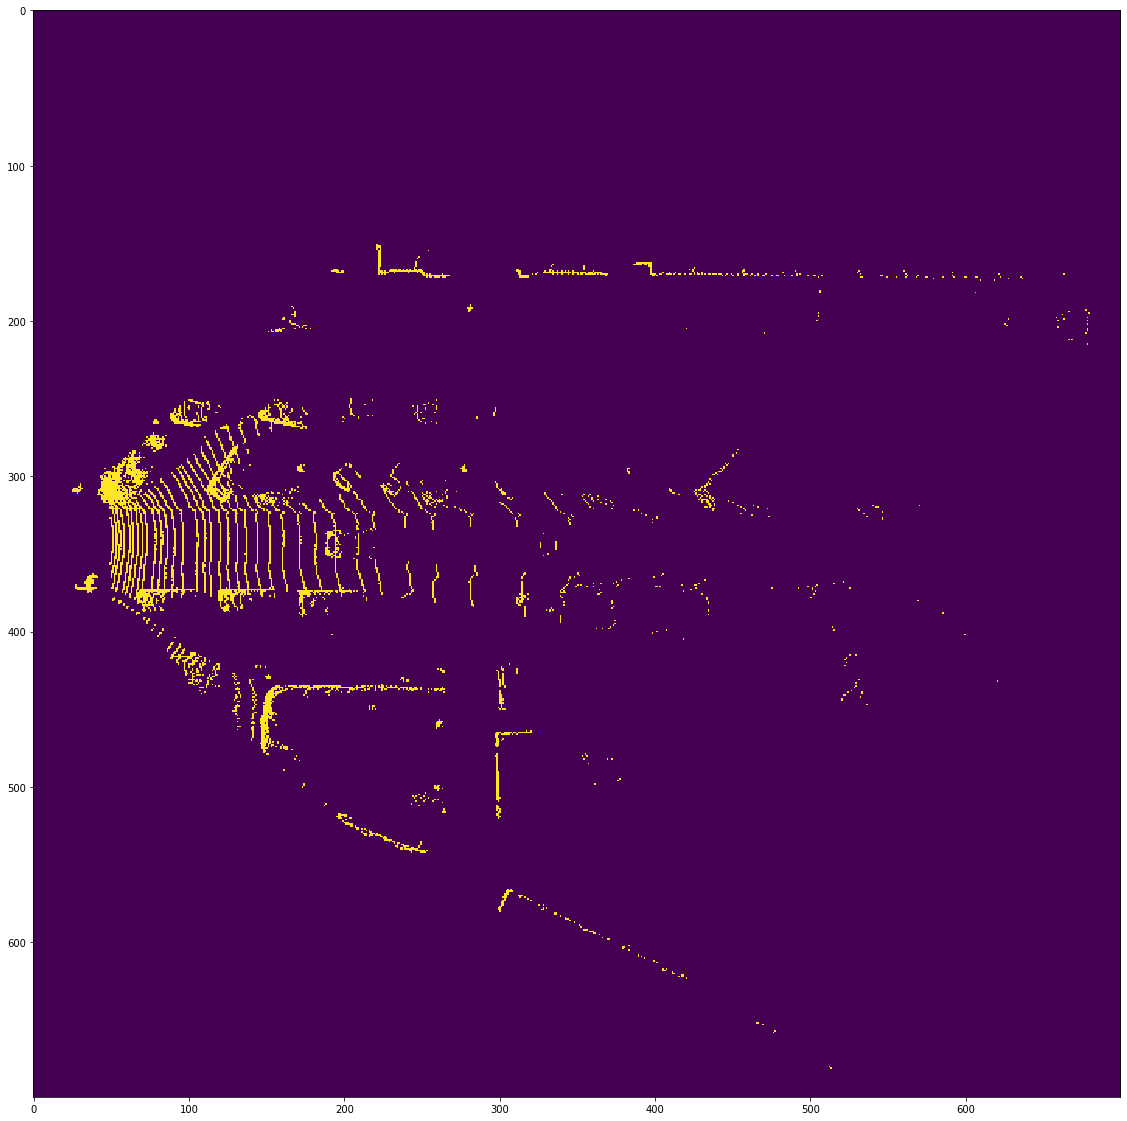

In [10]:
plt.figure(figsize = (20,20))
plt.imshow(np.squeeze(encoded_pc))

In [11]:
img = kitti.get_image(cur_idx)
print('img.shape', img.shape)

img.shape (375, 1242, 3)


In [12]:
V2C, R0, P2 = kitti.get_calib(cur_idx)
pprint.pprint(V2C)
pprint.pprint(R0)
pprint.pprint(P2)

array([[ 7.533745e-03, -9.999714e-01, -6.166020e-04, -4.069766e-03],
       [ 1.480249e-02,  7.280733e-04, -9.998902e-01, -7.631618e-02],
       [ 9.998621e-01,  7.523790e-03,  1.480755e-02, -2.717806e-01],
       [ 0.000000e+00,  0.000000e+00,  0.000000e+00,  1.000000e+00]])
array([[ 0.9999239 ,  0.00983776, -0.00744505,  0.        ],
       [-0.0098698 ,  0.9999421 , -0.00427846,  0.        ],
       [ 0.00740253,  0.00435161,  0.9999631 ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])
array([[7.215377e+02, 0.000000e+00, 6.095593e+02, 4.485728e+01],
       [0.000000e+00, 7.215377e+02, 1.728540e+02, 2.163791e-01],
       [0.000000e+00, 0.000000e+00, 1.000000e+00, 2.745884e-03],
       [0.000000e+00, 0.000000e+00, 0.000000e+00, 1.000000e+00]])


In [13]:
depth_img     = range_view(img=None, pts=pc, ref=ref, P2=P2, gt_boxes=None, pred_boxes=None, out_type='depth')
intensity_img = range_view(img=None, pts=pc, ref=ref, P2=P2, gt_boxes=None, pred_boxes=None, out_type='intensity')
height_img    = range_view(img=None, pts=pc, ref=ref, P2=P2, gt_boxes=None, pred_boxes=None, out_type='height')
print('depth_img.shape    ', depth_img.shape)
print('intensity_img.shape', intensity_img.shape)
print('height_img.shape   ', height_img.shape)

depth_img.shape     (375, 1242, 3)
intensity_img.shape (375, 1242, 3)
height_img.shape    (375, 1242, 3)


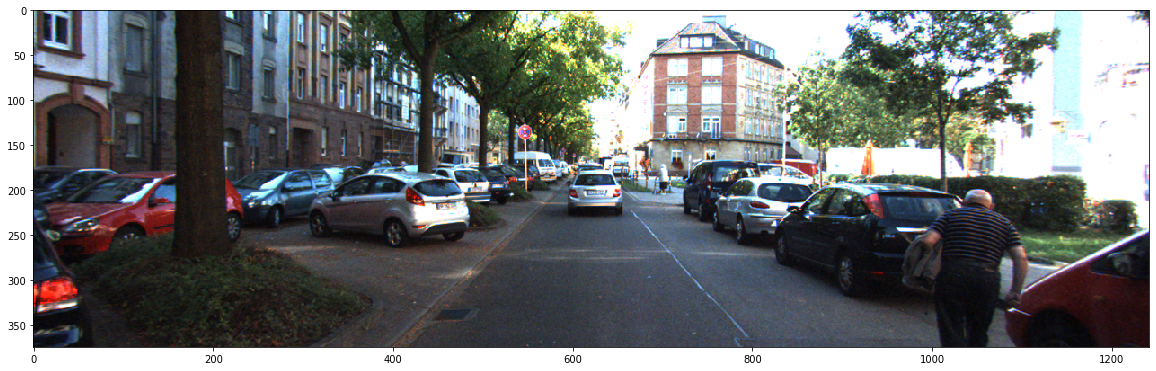

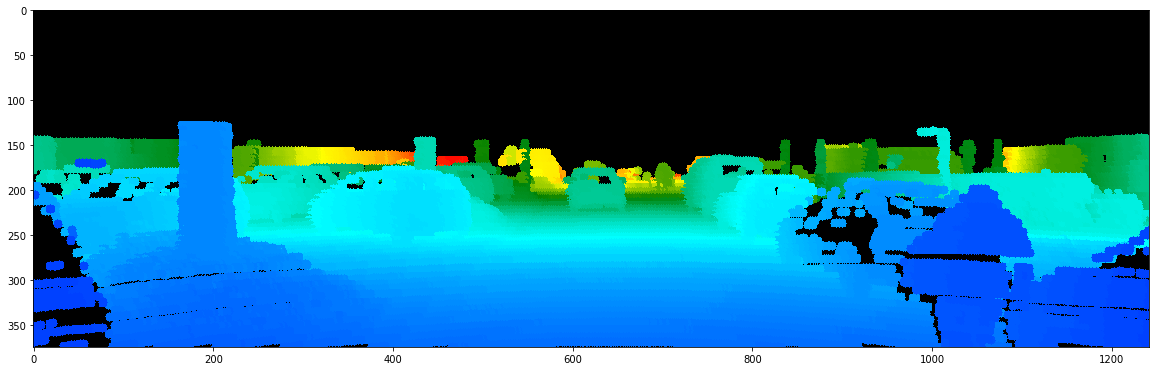

In [14]:
plt.figure(figsize = (20,10))
plt.imshow(img)

plt.figure(figsize = (20,8))
plt.imshow(depth_img)

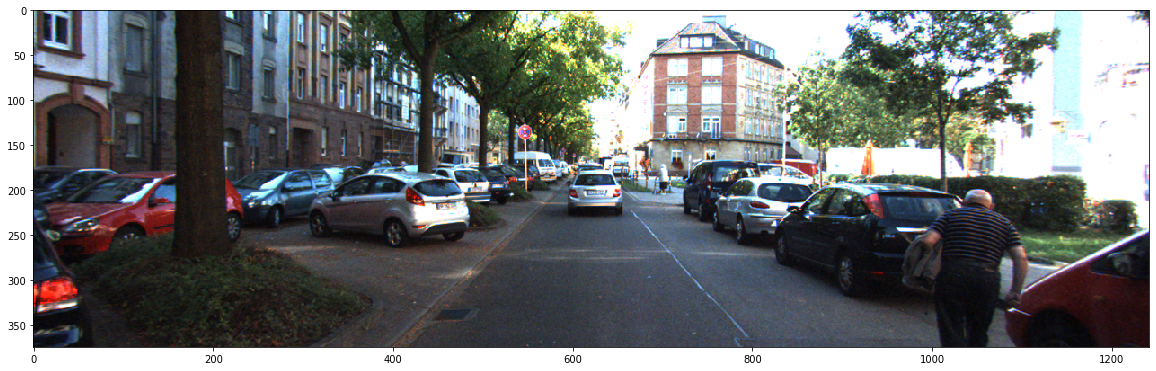

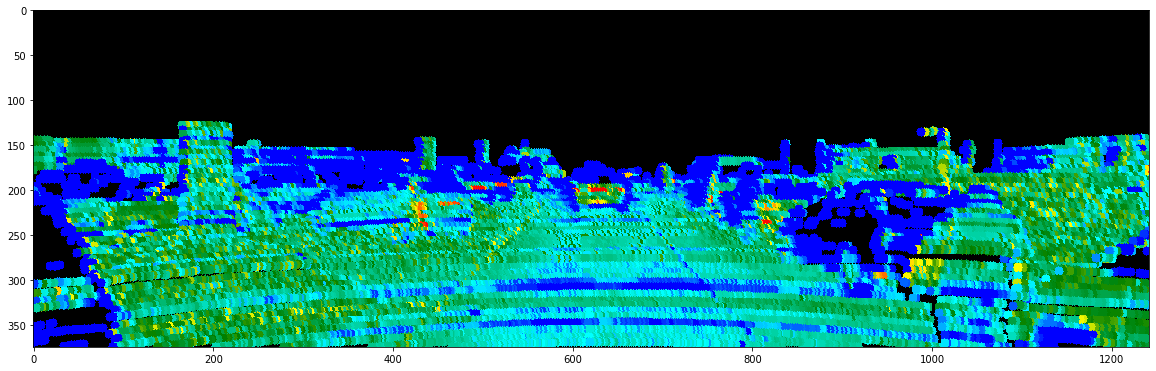

In [15]:
plt.figure(figsize = (20,10))
plt.imshow(img)

plt.figure(figsize = (20,8))
plt.imshow(intensity_img)

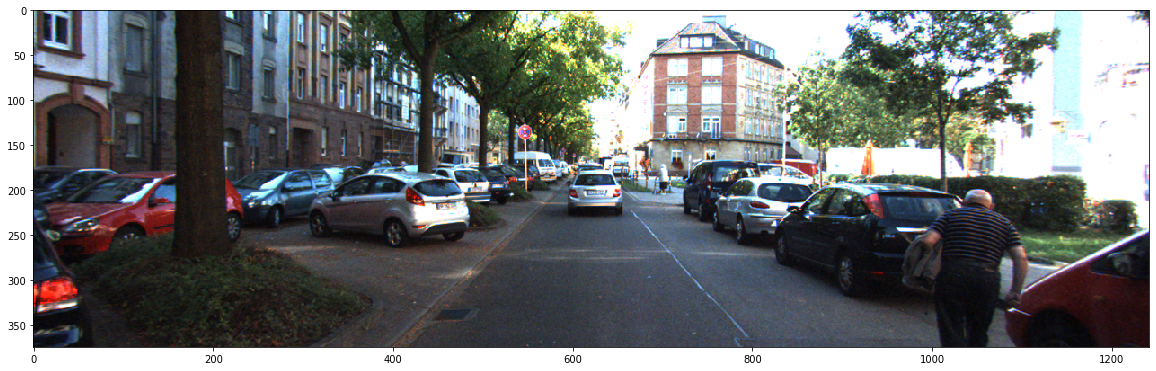

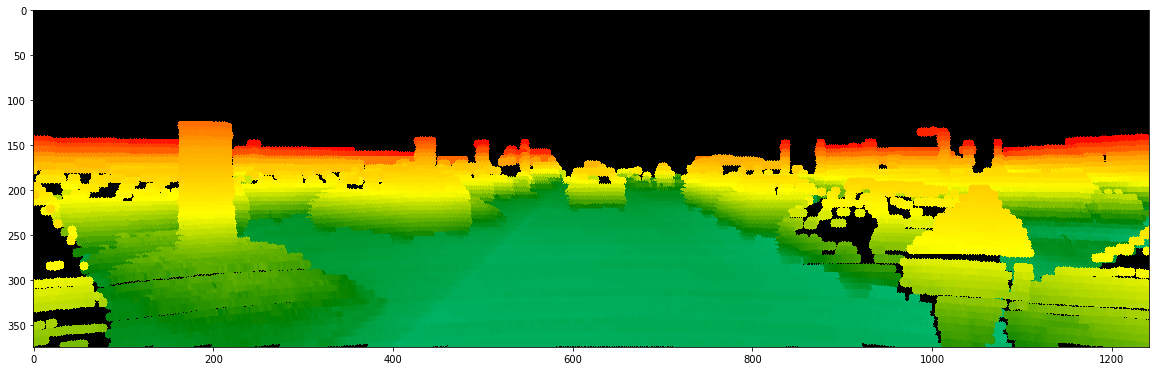

In [16]:
plt.figure(figsize = (20,10))
plt.imshow(img)

plt.figure(figsize = (20,8))
plt.imshow(height_img)